## Reverse Image Search

Using the principles of representation learning and vectorization of data we can quickly set up a reverse image search system. We will perform the following steps. 

* Import a pretrained neural network with the classification layer removed.
* Vectorize our query and search images using this pretrained network.
* Find the search images that most closly matches the query images using the extracted ConvNet features

In [44]:
# load the pretrained VGG16 network

from vgg16 import VGG16
from keras.preprocessing import image
from imagenet_utils import preprocess_input

model = VGG16(weights='imagenet', include_top=False)


K.image_dim_ordering: tf


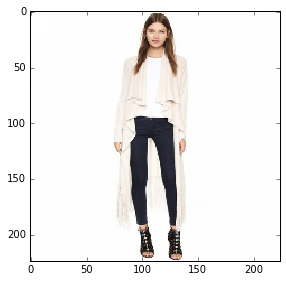

data/search_imgs/clothing-style-1.jpg


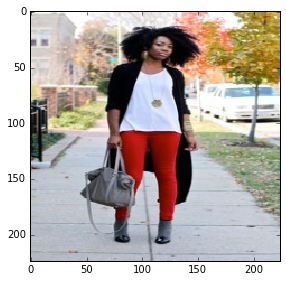

data/search_imgs/clothing-style-12.jpg


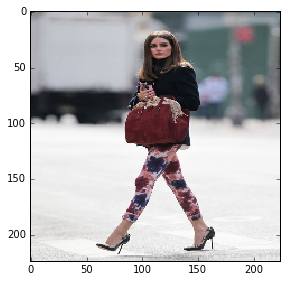

data/search_imgs/clothing-style-13.jpg


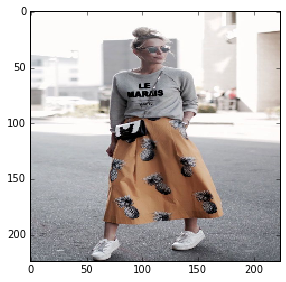

data/search_imgs/clothing-style-14.jpg


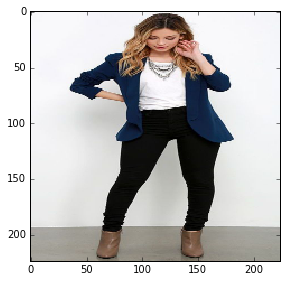

data/search_imgs/clothing-style-15.jpg


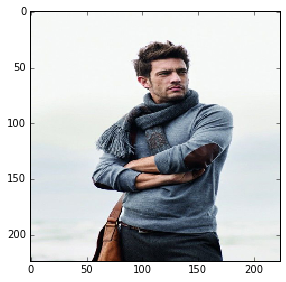

data/search_imgs/clothing-style-16.jpg


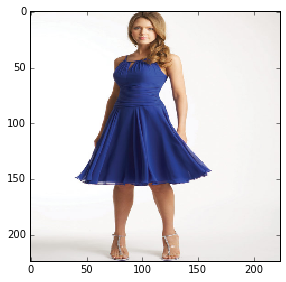

data/search_imgs/clothing-style-17.jpg


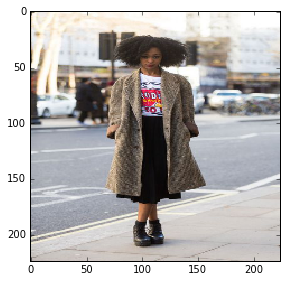

data/search_imgs/clothing-style-2.jpg


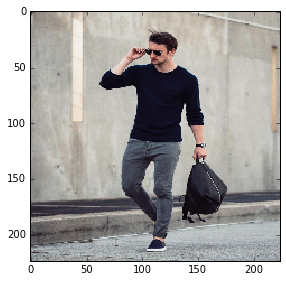

data/search_imgs/clothing-style-3.jpg


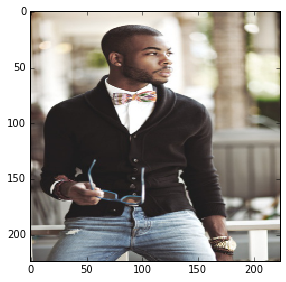

data/search_imgs/clothing-style-4.jpg


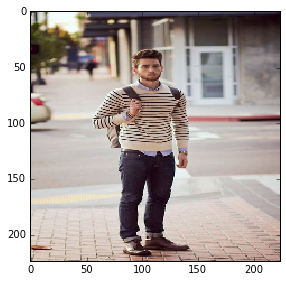

data/search_imgs/clothing-style-5.jpg


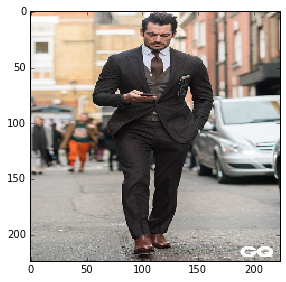

data/search_imgs/clothing-style-6.jpg


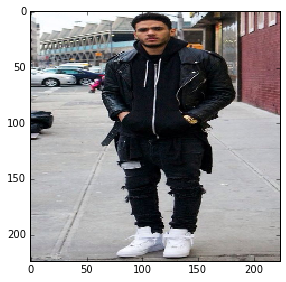

data/search_imgs/clothing-style-7.jpg


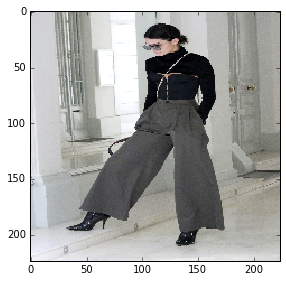

data/search_imgs/clothing-style-8.jpg


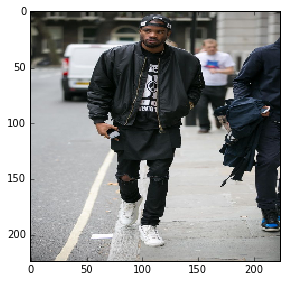

data/search_imgs/clothing-style-9.jpg


In [45]:
# load each image into a list
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.io import imshow, imread
from skimage import transform
import numpy as np
import glob

# make a function to preprocess each image
def preprocess_img(x):
    x = x[:,:,[2,1,0]]
    x[:,:,0] -= 103.939
    x[:,:,1] -= 116.779
    x[:,:,2] -= 123.68
    x = np.expand_dims(x, axis=0)
    return x

im_files = glob.glob('data/search_imgs/*')

search_imgs = []
search_imgs_orig = []
for im_path in im_files:
    img = imread(im_path)
    search_imgs_orig.append(img)
    img = transform.resize(img, output_shape=(224, 224 , 3), preserve_range=True)
    imshow(img / 255.)
    plt.show()
    print im_path
    img = preprocess_img(img)
    search_imgs.append(img)

In [46]:
# make a list of the featurized imags
search_ims_feats = []
for im in search_imgs:
    search_ims_feats.append(model.predict(im).flatten())
    
print search_ims_feats[0].shape

(25088,)


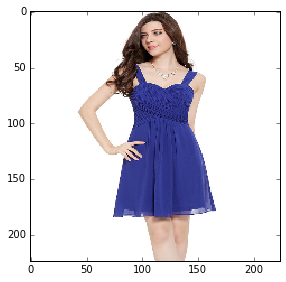

In [47]:
# get the query image
q_img = imread('data/query_img/query_dress.jpg')
q_img = transform.resize(q_img, output_shape=(224, 224 , 3), preserve_range=True)
imshow(q_img / 255.)
plt.show()

In [48]:
# prepross it and get the features
q_proc = preprocess_img(q_img)
q_vec = model.predict(q_proc).flatten()
print q_vec.shape

(25088,)


6


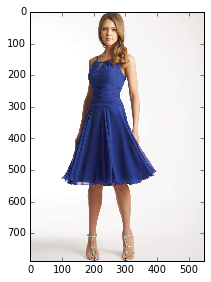

In [49]:
# compute the cosine distance between the query img and all of the others
from scipy import spatial

distances = []
for s_vec in search_ims_feats:
    distances.append(spatial.distance.cosine(q_vec, s_vec))
    
print np.argmin(distances)

imshow(search_imgs_orig[np.argmin(distances)] / 255.)
plt.show()